In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=1000,random_state=42,noise=0.03)

X[:5],y[:5],len(X),len(y)

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]),
 1000,
 1000)

In [3]:
import pandas as pd

In [4]:
#make dataframe from the circles data
circles = pd.DataFrame({
    "X1":X[:,0],
    "X2":X[:,1],
    "label":y
})

In [5]:
circles[:5]

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


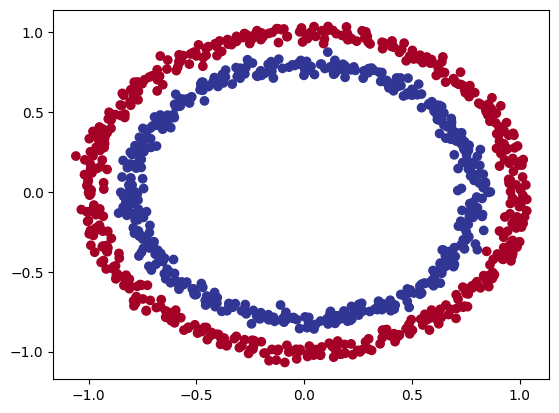

In [6]:
# visualizing the dataframe
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]
X_sample,y_sample,X_sample.shape,y_sample.shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

Now turning the data into tensors and train test splitting

In [9]:
import torch
torch.__version__

'2.5.1+cu124'

In [10]:
type(X) 

numpy.ndarray

In [11]:
# turning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [12]:
X.dtype,y.dtype

(torch.float32, torch.float32)

In [13]:
# splitting data into training and testing dataset
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## Building the model

In [14]:
from torch import nn

In [15]:
# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)
    
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # input (x) -> layer 1 -> layer 2 -> output

#creating an instance of our model and passing it through our device
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# replicating the model with sequential 
model0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5396,  0.1052],
                      [-0.1378, -0.1916],
                      [-0.1296,  0.3417],
                      [ 0.2863, -0.4667],
                      [-0.1248, -0.5033]])),
             ('0.bias', tensor([ 0.3040, -0.3729, -0.2760,  0.5027, -0.2033])),
             ('1.weight',
              tensor([[ 0.3586, -0.3957, -0.0285,  0.3855,  0.4000]])),
             ('1.bias', tensor([-0.1789]))])

In [19]:
# make predicitons
with torch.inference_mode():
    untrained_preds = model0(X_test.to(device))
print(f"{len(untrained_preds)},{untrained_preds.shape}")
print(f"{len(X_test)},{X_test.shape}")
print(f"first 10 predictions{untrained_preds[:10]}")
print(f"first 10 labels{y_test[:10]}")


200,torch.Size([200, 1])
200,torch.Size([200, 2])
first 10 predictionstensor([[ 0.0367],
        [-0.0695],
        [ 0.3379],
        [-0.0488],
        [ 0.3742],
        [ 0.3092],
        [-0.0186],
        [ 0.0702],
        [ 0.3359],
        [-0.0762]])
first 10 labelstensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
# using loss functin
# loss_fn = nn.BCELoss() #just a plain bce loss

loss_fn = nn.BCEWithLogitsLoss() # it combines bce loss with sigmoid activation function builtin and more numerically stable as per the docs.
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.01)


In [21]:
# calculating accuracy out of 100 examples

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [22]:
# viewing the first 5 o/p of the forward pass on the test data
model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test.to(device))[:5] #logits are the raw ouput of our model without being passed to any activation function
y_logits

tensor([[ 0.0367],
        [-0.0695],
        [ 0.3379],
        [-0.0488],
        [ 0.3742]])

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
#lets run the logits through sigmoid activation to turn them into prediciton probabilities.
y_pred_props = torch.sigmoid(y_logits)
y_pred_props

tensor([[0.5092],
        [0.4826],
        [0.5837],
        [0.4878],
        [0.5925]])

 range style rounding is required in our prediction probability values
 * for y_pred_props >=0.5, y=1
 * for y_pred_props <0.5, y=0


In [25]:
y_preds = torch.round(y_pred_props)

# logits -> pred props -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

#checking for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.])

### Training and Testing loops

In [26]:
torch.manual_seed(42)

epochs = 100

# putting data to target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test= X_test.to(device)
y_test= y_test.to(device)

# building the training and evaluation loop
for epoch in range(epochs):
    model0.train()

    # 1. forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    '''
    So basically, what a model does is predicts and generates a value i.e. 'logits'. It 
    converts them into prediction probabilites(meaningful prediction) and then into prediction 
    labels.   
    logits ---> pred probabs. ---> pred labels
    '''

    # 2. calculate loss/accuracy
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true= y_train,
                      y_pred=y_pred)
    '''
    Since we used BCELossWithLogits as loss function, we pass logits. In case we didnot use
    that, other loss function like BCELoss would require preds probabs to be passed.
    
    loss = loss_fn(torch.sigmoid(y_logits),y_train) for BCELoss.
    '''

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step step step (gradient descent) (updating the params)
    optimizer.step()


    ## Testing
    model0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # printing out what's happening
    if epoch % 10 == 0:
        print(f"Epochs:{epoch}| loss:{loss:.5f}, accuracy:{acc:.2f}| test loss:{test_loss:.5f}, test accuracy:{test_acc:.2f}")


Epochs:0| loss:0.70407, accuracy:55.25| test loss:0.69484, test accuracy:53.50
Epochs:10| loss:0.70338, accuracy:54.25| test loss:0.69435, test accuracy:53.50
Epochs:20| loss:0.70275, accuracy:53.50| test loss:0.69391, test accuracy:53.00
Epochs:30| loss:0.70218, accuracy:53.87| test loss:0.69352, test accuracy:53.00
Epochs:40| loss:0.70166, accuracy:53.50| test loss:0.69318, test accuracy:54.00
Epochs:50| loss:0.70118, accuracy:52.88| test loss:0.69288, test accuracy:54.50
Epochs:60| loss:0.70075, accuracy:52.50| test loss:0.69261, test accuracy:54.00
Epochs:70| loss:0.70035, accuracy:52.12| test loss:0.69237, test accuracy:54.00
Epochs:80| loss:0.69999, accuracy:51.50| test loss:0.69215, test accuracy:53.50
Epochs:90| loss:0.69966, accuracy:51.62| test loss:0.69196, test accuracy:54.00


Since we didnot get better accuracy and it is saturated at 50%, we'll try to understand it 
by visualizing

In [27]:
import requests
from pathlib import Path

# download helper function for decision boundary plot and many more
if Path("helper_functions.py").is_file():
    print("Helper function already exists! Skipping download!")
else:
    print("Downloading...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Downloading...


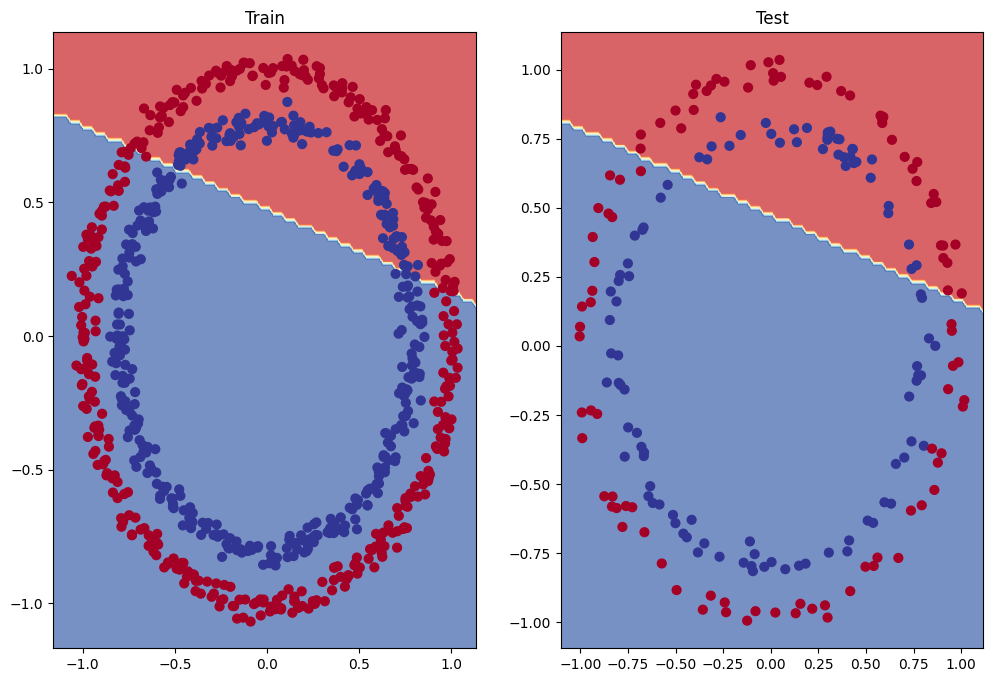

In [34]:
# Plotting the boundary tree
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0,X_test,y_test)

#### What can we possibly do to improve our model?
1. adding more layers
2. increasing the number of neurons in the hidden layers
3. increasing the number of epochs
4. changing the activation function
5. changing the optimizer
6. changing the loss function
7. changing the learning rate
8. adding regularization 
9. adding batch normalization layers


![Image](/home/bigyan/Desktop/pytorch_for_deep_learning/course_lessons/images/improvement.png)

In [38]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        """
        Defines the forward pass of the neural network.
        z is logits (what we call the raw output)

        Args:
            x (torch.Tensor): Input tensor to the neural network.

        Returns:
            torch.Tensor: Output tensor after passing through the network layers.
        """
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way to write properly

model1 = CircleModelV1().to(device)
model1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)

In [51]:
epochs = 1000

for epoch in range(epochs):
    model1.train()
    
    y_logits = model1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epochs:{epoch}| loss:{loss:.5f}, accuracy:{acc:.2f}| test loss:{test_loss:.5f}, test accuracy:{test_acc:.2f}")





Epochs:0| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:10| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:20| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:30| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:40| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:50| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:60| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:70| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:80| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:90| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:100| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:110| loss:0.69298, accuracy:51.00| test loss:0.69468, test accuracy:46.00
Epochs:120| loss:0.69298, accuracy:51.0

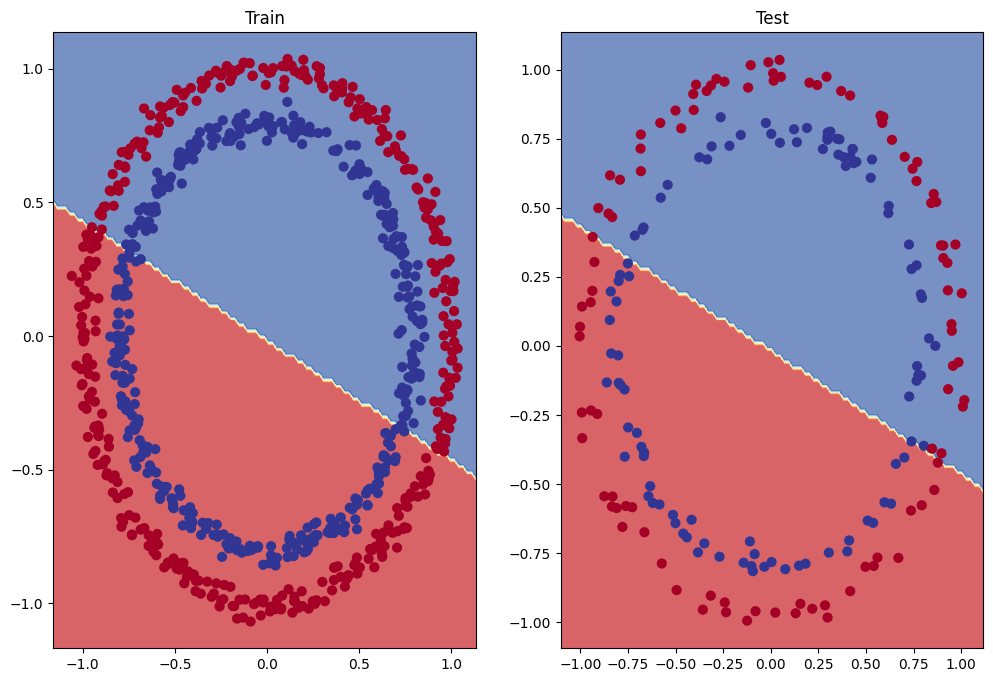

In [52]:
# Plotting the boundary tree
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1,X_test,y_test)